In [63]:
import torch
import torchvision
import pytorch_lightning as pl
from torch.nn import ReLU, Flatten, Linear, Unflatten, Tanh

from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, silhouette_samples
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
from scipy import stats

In [2]:
LATENT_DIM = 10

In [3]:
data = torchvision.datasets.MNIST(".", download=True, transform=torchvision.transforms.ToTensor())
test = torchvision.datasets.MNIST(".", download=True, transform=torchvision.transforms.ToTensor(), train=False)
dataloader = torch.utils.data.DataLoader(data, batch_size=512, num_workers = 11, shuffle=True, persistent_workers=True, drop_last=True)
dataloader_test = torch.utils.data.DataLoader(test, batch_size=10_000, num_workers = 11, persistent_workers=True)

In [4]:
class Encoder(torch.nn.Module):
    def __init__(self, latent_dim) -> None:
        super().__init__()
        self.base = torch.nn.Sequential(
            Flatten(),
            Linear(784, 256),
            ReLU(),
            Linear(256, 256),
            ReLU(),
            Linear(256, 256),
            ReLU(),
            Linear(256, 256),
            ReLU(),
        )
        self.mean_head = torch.nn.Sequential(
            Linear(256, latent_dim)
        )
        self.log_var_head = torch.nn.Sequential(
            Linear(256, latent_dim)
        )
    def forward(self, X):
        base = self.base(X)
        mean = self.mean_head(base)
        log_var = self.log_var_head(base)
        return {
            "mean": mean,
            "log_var": log_var
        }
        

In [5]:
from typing import Any


class VAE(pl.LightningModule):



    def __init__(self,encoder ,decoder, regularisation = 0.5,  *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.regularisation = regularisation

    def ELBO(self, X, X_hat, Z_mean, Z_log_var):
        reproduction_loss = torch.nn.functional.mse_loss(X_hat, X, reduction="sum")
        divergence_loss = self.regularisation * torch.sum(-Z_log_var + torch.exp(Z_log_var) + Z_mean**2 - 1)

        self.log("reproduction_loss", reproduction_loss)
        self.log("divergence_loss", divergence_loss)

        return reproduction_loss + divergence_loss

    def sample(self, parameters):
        mean = parameters["mean"]
        log_var = parameters["log_var"]
        eps = torch.randn_like(mean, requires_grad=True)
        return eps * torch.exp(0.5 * log_var) + mean

    def forward(self,X, *args: Any, **kwargs: Any) -> Any:
        z = self.encoder(X)
        X_repr = self.decoder(z)
        return X_repr
    def training_step(self, batch, batch_idx):
        X, y = batch
        z_params = self.encoder(X)
        z = self.sample(z_params)
        X_repr = self.decoder(z)

        loss = self.ELBO(X, X_repr, z_params["mean"], z_params["log_var"]).mean()
        self.log("train_loss", loss, True)
        return loss
    def validation_step(self, batch, **kwargs: Any):
        X, y = batch
        z = self.encoder(X)["mean"]
        X_repr = self.decoder(z)
        loss = torch.nn.functional.mse_loss(X, X_repr)
        self.log("val_loss", loss, True)
        self.logger.experiment.add_images(f"repr", X_repr[0:10,:], self.current_epoch, dataformats="NCHW")
        self.logger.experiment.add_images(f"orig", X[0:10,:], self.current_epoch, dataformats="NCHW")
        return loss
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    

In [6]:
def get_encoder_decoder(latent_dim):
    encoder_linear = Encoder(latent_dim)
    decoder = torch.nn.Sequential(
    torch.nn.Linear(latent_dim, 256),
    ReLU(),
    Linear(256, 256),
    ReLU(),
    Linear(256, 256),
    ReLU(),
    Linear(256, 256),
    ReLU(),
    Linear(256, 784),
    Unflatten(-1, (1, 28, 28)))
    return encoder_linear, decoder


In [7]:
vae_encoder, vae_decoder = get_encoder_decoder(LATENT_DIM)
vae = VAE(vae_encoder, vae_decoder, regularisation=0.5)

In [8]:
trainer = pl.Trainer(max_epochs=300, enable_checkpointing=False)
trainer.fit(vae, train_dataloaders=dataloader, val_dataloaders=dataloader_test)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Encoder    | 403 K 
1 | decoder | Sequential | 401 K 
---------------------------------------
805 K     Trainable params
0         Non-trainable params
805 K     Total params
3.221     Total estimated model params size (MB)


Epoch 299: 100%|██████████| 117/117 [00:03<00:00, 37.59it/s, v_num=0, train_loss=1.54e+4, val_loss=0.0254]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 117/117 [00:03<00:00, 37.54it/s, v_num=0, train_loss=1.54e+4, val_loss=0.0254]


In [9]:
from typing import Any
import math

class VADE(VAE):
    def __init__(self, encoder, decoder, scheduler, n_clusters, latent_dim, regularisation=0.5, *args: Any, **kwargs: Any) -> None:
        super().__init__(encoder, decoder, regularisation, *args, **kwargs)
        self.scheduler = scheduler
        self.cluster_prob_logits = torch.nn.Parameter(torch.randn((n_clusters)))
        self.cluster_means = torch.nn.Parameter(torch.randn((n_clusters, latent_dim)))
        self.cluster_log_vars = torch.nn.Parameter(torch.zeros((n_clusters, latent_dim)))
    def ELBO(self, X, X_hat, Z_mean, Z_log_var):

        Z = self.sample({"mean":Z_mean, "log_var":Z_log_var}).unsqueeze(1)
        h = Z - self.cluster_means
        h = torch.exp(-0.5 * torch.sum(h**2/torch.exp(self.cluster_log_vars), dim=2))
        h = h/torch.exp(torch.sum(0.5 * self.cluster_log_vars, dim=1))
        p_z_given_c = h / (2 * math.pi)
        p_z_c = p_z_given_c * (torch.nn.functional.softmax(self.cluster_prob_logits, dim=0)) + 1e-9
        gamma = p_z_c / (torch.sum(p_z_c, dim=1, keepdim=True))
        h = self.cluster_log_vars.exp().unsqueeze(1) + (self.cluster_means.unsqueeze(1) - self.cluster_means).pow(2)
        h = torch.sum(self.cluster_log_vars + h / self.cluster_log_vars.exp(), dim=2)

        X_hat = self.decoder(Z.squeeze())
        reproduction_loss = torch.nn.functional.mse_loss(X_hat, X, reduction="sum")
        
        gamma = gamma.unsqueeze(1)
        divergence_loss = 0.5 * torch.sum(gamma * h) \
            - torch.sum(gamma * torch.log(torch.nn.functional.softmax(self.cluster_prob_logits, dim=0) + 1e-9)) \
            + torch.sum(gamma * torch.log(gamma + 1e-9)) \
            - 0.5 * torch.sum(1 + self.cluster_log_vars)
        
        ###
        # log losses
        self.log("tran_loss", reproduction_loss + divergence_loss * self.scheduler(self.current_epoch) * self.regularisation / X.shape[0], True)
        self.log("reproduction_loss", reproduction_loss)
        self.log("divergence_loss", divergence_loss)


        ########
        divergence_loss = torch.clamp(divergence_loss, min=-10000, max=10000)
        return reproduction_loss + divergence_loss * self.scheduler(self.current_epoch) * self.regularisation / X.shape[0]

    def training_step(self, batch, batch_idx):
        X, y = batch
        z_params = self.encoder(X)
        # print(X.shape, X_repr.shape)

        loss = self.ELBO(X, None, z_params["mean"], z_params["log_var"]).mean()
        # self.log("train_loss", loss, True)
        return loss
    
    def validation_step(self, batch, **kwargs: Any):
        X, y = batch
        z = self.encoder(X)["mean"]
        X_repr = self.decoder(z)
        loss = torch.nn.functional.mse_loss(X, X_repr)
        self.log("val_loss", loss, True)
        self.logger.experiment.add_images(f"repr", X_repr[0:10,:], self.current_epoch, dataformats="NCHW")
        self.logger.experiment.add_images(f"orig", X[0:10,:], self.current_epoch, dataformats="NCHW")
        return loss
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

In [10]:
class linear_scheduler():
    def __init__(self, start, stop) -> None:
        self.start = start
        self.stop = stop
    def __call__(self, epoch):
        if epoch < self.start:
            return 0
        elif epoch > self.stop:
            return 1
        else:
            return (epoch - self.start)/(self.stop - self.start)

In [11]:
class step_scheduler():
    def __init__(self, step) -> None:
        self.step = step
    def __call__(self, epoch):
        return 0 if epoch < self.step else 1

In [79]:
vade_encoder, vade_decoder = get_encoder_decoder(LATENT_DIM)
vade = VADE(vade_encoder, vade_decoder, linear_scheduler(70, 80), 10, LATENT_DIM, regularisation=1)

In [80]:
trainer = pl.Trainer(max_epochs=300, enable_checkpointing=False)

trainer.fit(vade, train_dataloaders=dataloader, val_dataloaders=dataloader_test)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder      | Encoder    | 403 K 
1 | decoder      | Sequential | 401 K 
  | other params | n/a        | 210   
--------------------------------------------
805 K     Trainable params
0         Non-trainable params
805 K     Total params
3.221     Total estimated model params size (MB)


Epoch 299: 100%|██████████| 117/117 [00:03<00:00, 33.07it/s, v_num=3, tran_loss=6.26e+3, val_loss=0.0134]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 117/117 [00:03<00:00, 33.05it/s, v_num=3, tran_loss=6.26e+3, val_loss=0.0134]


In [81]:
with torch.no_grad():
    vae_Z = vae_encoder(test.data/255)["mean"].detach()
    vade_Z = vade_encoder(test.data/255)["mean"].detach()

Text(0.5, 1.0, 'T-SNE of VAE latent space')

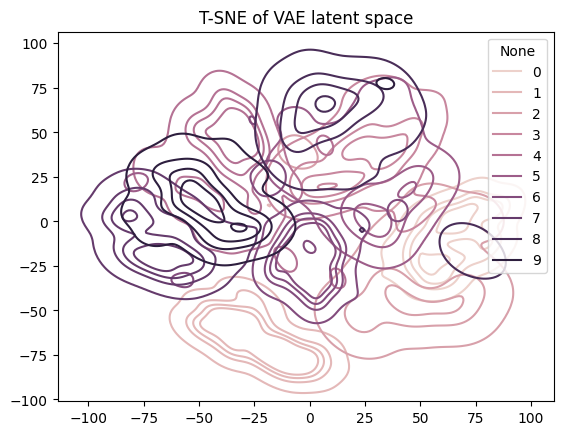

In [17]:
tsne = TSNE()
Z_transformed = tsne.fit_transform(vae_Z)
sns.kdeplot(x=Z_transformed[:,0], y=Z_transformed[:,1], hue=test.targets, levels=5)
plt.title("T-SNE of VAE latent space")

Text(0.5, 1.0, 'T-SNE of VaDE latent space')

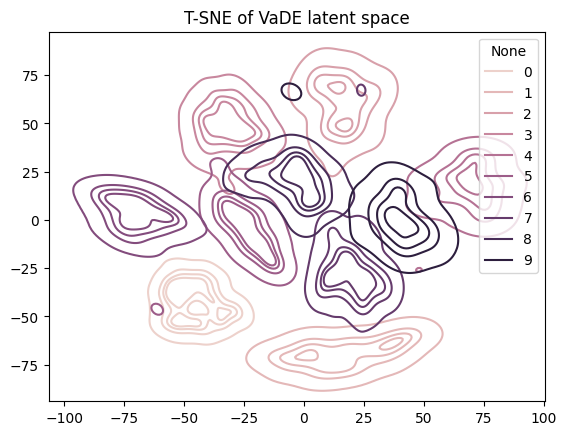

In [82]:
tsne = TSNE()
Z_transformed = tsne.fit_transform(vade_Z)
sns.kdeplot(x=Z_transformed[:,0], y=Z_transformed[:,1], hue=test.targets, levels=5)
plt.title("T-SNE of VaDE latent space")

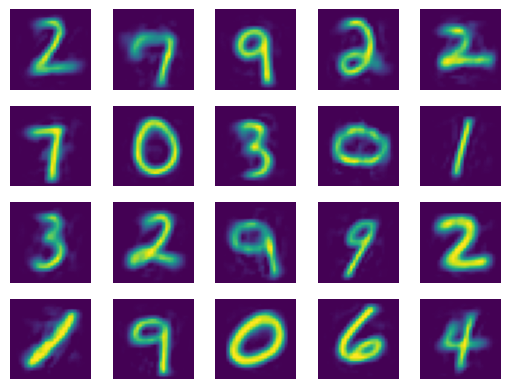

In [22]:
# sample from VAE
n=20

z_samples = stats.multivariate_normal(mean=[0] * LATENT_DIM).rvs(n)

with torch.no_grad():
    x_samples = vae_decoder(torch.from_numpy(z_samples).type("torch.FloatTensor")).numpy()

fig, ax = plt.subplots(n//5, 5)
for i, img in enumerate(x_samples):
    ax[i//5, i%5].imshow(img.squeeze().clip(0, 1))
    ax[i//5, i%5].axis('off')

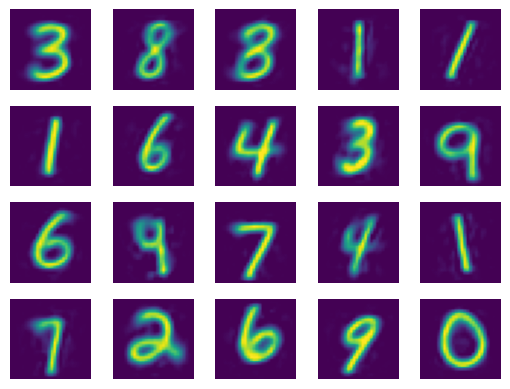

In [44]:
# sample from VAE - GMM

vae_gmm = GaussianMixture(10, covariance_type='diag')
vae_gmm.fit(vae_Z)

vae_Y = vae_gmm.predict(vae_Z)
n=20

z_samples, y_samples = vae_gmm.sample(n)

with torch.no_grad():
    x_samples = vae_decoder(torch.from_numpy(z_samples).type("torch.FloatTensor")).numpy()
    
fig, ax = plt.subplots(n//5, 5)
for i, img in enumerate(x_samples):
    ax[i//5, i%5].imshow(img.squeeze().clip(0, 1))
    ax[i//5, i%5].axis('off')

In [67]:
silhouette_samples(np.concatenate([vae_Z, z_samples]), np.concatenate([vae_Y, y_samples]))[:-n].mean()

0.06454223179464502

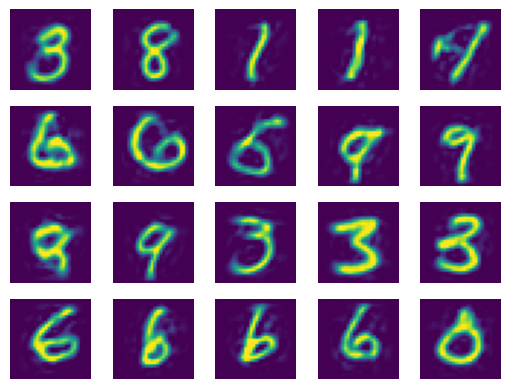

In [84]:
# sample from VADE

vade_gmm = GaussianMixture(10, covariance_type='diag')

vade_gmm.fit(vade_Z)

vade_Y = vade_gmm.predict(vade_Z)

n=20

z_samples = vade_gmm.sample(n)[0]

with torch.no_grad():
    x_samples = vade_decoder(torch.from_numpy(z_samples).type("torch.FloatTensor")).numpy()

fig, ax = plt.subplots(n//5, 5)
for i, img in enumerate(x_samples):
    ax[i//5, i%5].imshow(img.squeeze().clip(0, 1))
    ax[i//5, i%5].axis('off')

In [85]:
silhouette_samples(np.concatenate([vade_Z, z_samples]), np.concatenate([vade_Y, y_samples]))[:-n].mean()

0.20476224035690962

In [86]:
Y = test.targets.numpy()

In [60]:
adjusted_rand_score(vae_Y, Y), adjusted_mutual_info_score(vae_Y, Y), silhouette_score(vae_Z, vae_Y)

(0.3689085030812702, 0.5099211308670506, 0.06494459)

In [87]:
adjusted_rand_score(vade_Y, Y), adjusted_mutual_info_score(vade_Y, Y), silhouette_score(vade_Z, vade_Y)

(0.7053271474467535, 0.7785487675144525, 0.20522109)